<a href="https://colab.research.google.com/github/25thGilbertsProblem/NeuralNet-tests/blob/main/pneumonia_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение больных/здоровых легких с помощью CNN на основе датасета Chest X-Ray Images (Pneumonia)

### Импорты 

In [2]:
! pip install -q kaggle

In [3]:
# Для начала выгрузим датасет из Kaggle
import json
import zipfile
import os

In [4]:
from google.colab import files
files.upload() #последний API Token 

Saving kaggle-8.json to kaggle-8.json


{'kaggle-8.json': b'{"username":"klevtsovalexandr","key":"74b02bc5b57f4a30fa8ad42135640912"}'}

In [5]:
!mkdir -p ~/.kaggle
!echo '{"username":"klevtsovalexandr","key":"74b02bc5b57f4a30fa8ad42135640912"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/

 99% 2.28G/2.29G [00:27<00:00, 64.1MB/s]
100% 2.29G/2.29G [00:27<00:00, 88.6MB/s]


In [6]:
#Распакуем:
import zipfile
with zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

os.listdir('/content/chest_xray')

['test', 'val', 'train', 'chest_xray', '__MACOSX']

In [7]:
#Основные импорты: 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
import glob

# Модули keras
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model

### Визуализация датасета

In [ ]:
#Раскидаем test,train,val по переменным

TRAIN_DIR = "/content/chest_xray/train"
TEST_DIR = "/content/chest_xray/test"
VAL_DIR = "/content/chest_xray/val"

Число легких с пневмонией:  3875
Число здоровых легких:  1341
\\\\


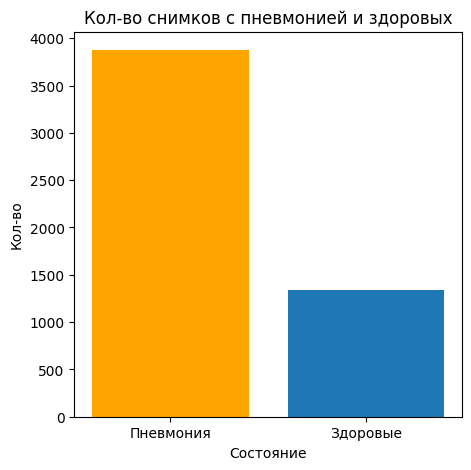

In [ ]:
# Разбиение на классы

pneumonia_cases = len(os.listdir(os.path.join(TRAIN_DIR , "PNEUMONIA")))
normal_cases = len(os.listdir(os.path.join(TRAIN_DIR , "NORMAL")))

print("Число легких с пневмонией: ", pneumonia_cases)
print("Число здоровых легких: ", normal_cases)
print("\\\\\\\\")

labels = ['Пневмония', 'Здоровые']
values = [pneumonia_cases, normal_cases]

fig = plt.figure(figsize=(5, 5))

#График
plt.bar(labels, values, width=0.8)
plt.bar(labels[0], values[0], color='orange', width=0.8)

plt.xlabel("Состояние")
plt.ylabel("Кол-во")
plt.title("Кол-во снимков с пневмонией и здоровых")

plt.show()

Видно, что случае с пневмонией сильно больше. Как я понял, это связано с тем, что при сборе данных интересовались именно случаями с заболеванием. Посмотрим на некоторые изображения:

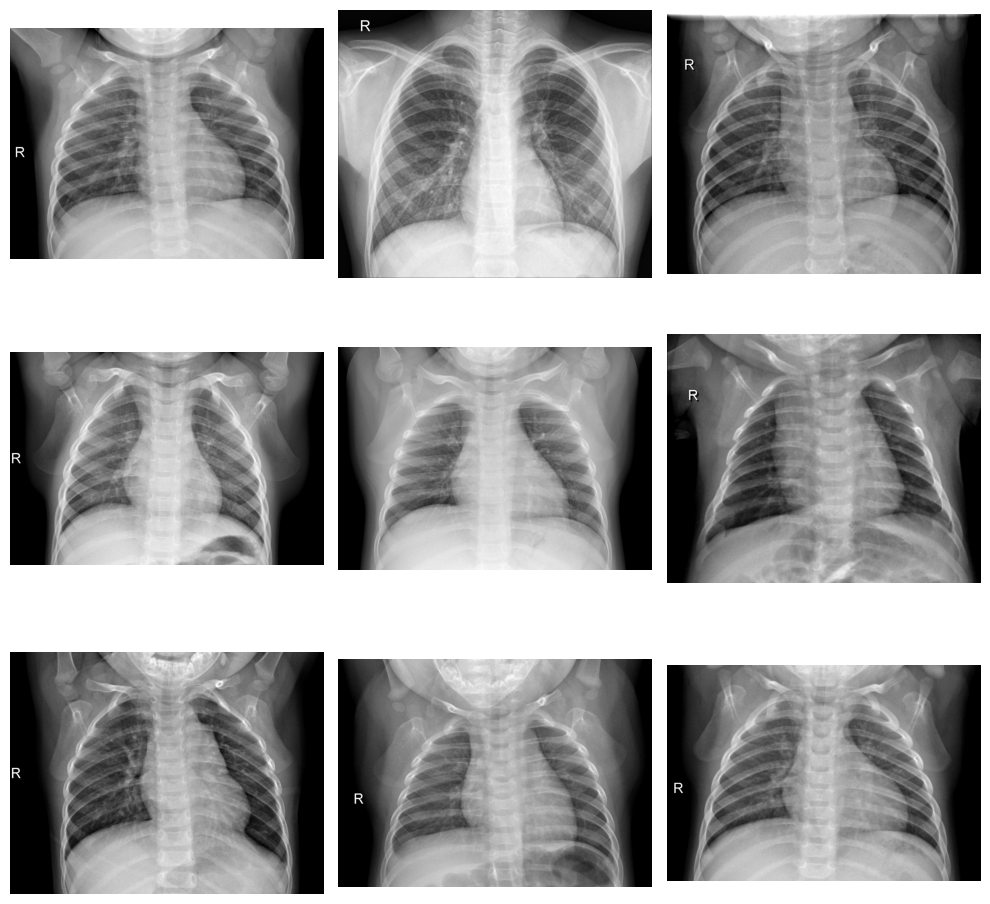

In [ ]:
#Здоровые легкие 

normal = os.listdir("/content/chest_xray/train/NORMAL")
normal_dir = "/content/chest_xray/train/NORMAL"


plt.figure(figsize=(10, 10))


for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()


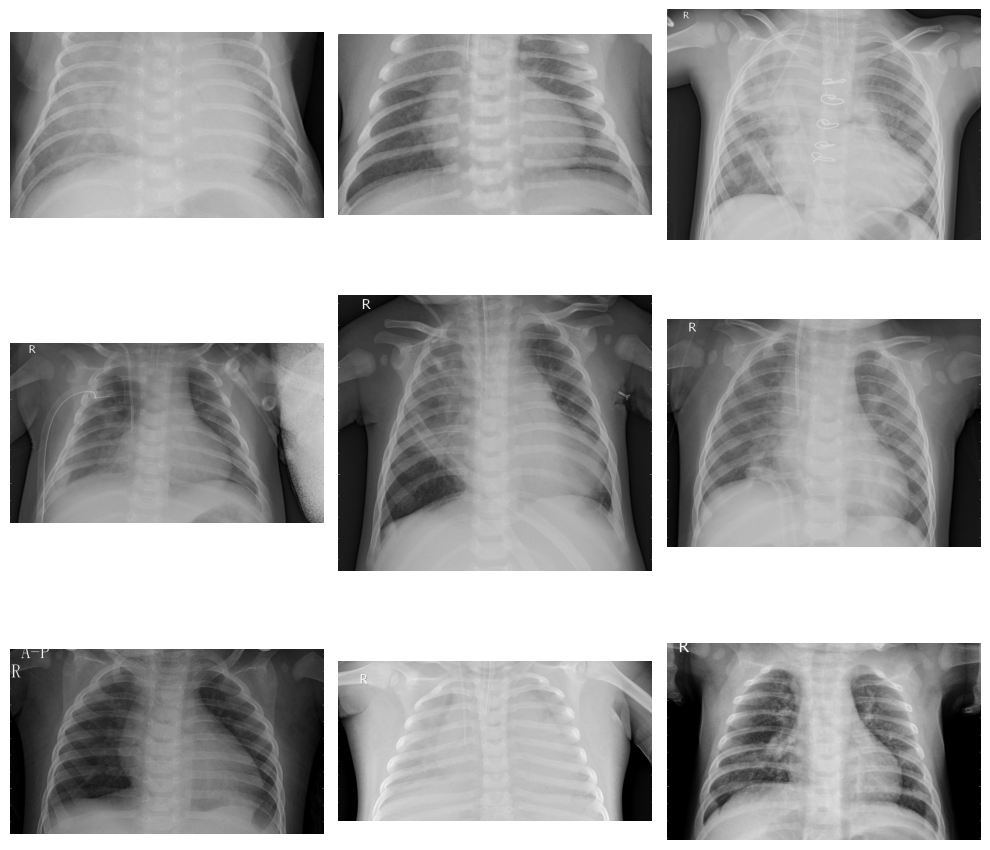

In [ ]:
#Пневмония 

# os.listdir('/content/chest_xray')

pneumonia = os.listdir("/content/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/content/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

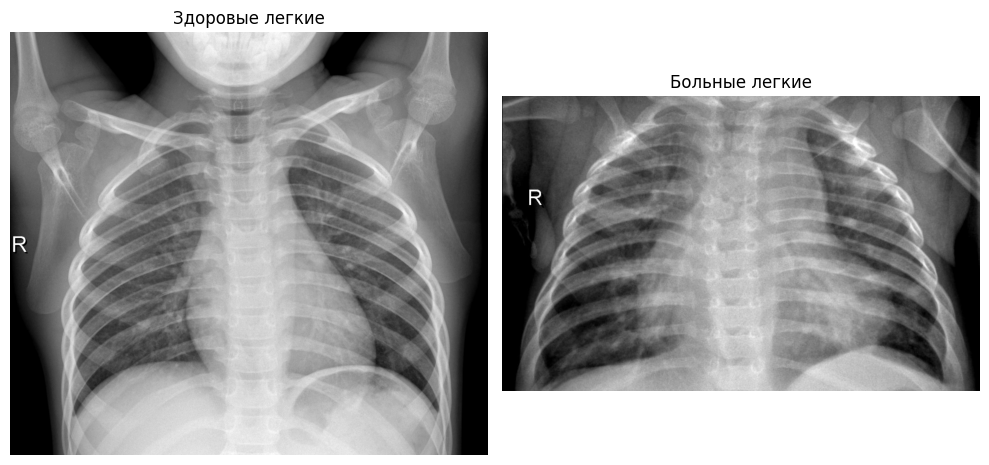

In [ ]:
# Посмотрим на вирусную и бактериальную пневмонию
normal_img = os.listdir("/content/chest_xray/train//NORMAL")[10]
normal_dir = "/content/chest_xray/train//NORMAL"
sample_img_1 = plt.imread(os.path.join(normal_dir, normal_img))


pneum_img = os.listdir("/content/chest_xray/train//PNEUMONIA")[10]
pneum_dir = "/content/chest_xray/train//PNEUMONIA"
sample_img_2 = plt.imread(os.path.join(pneum_dir, pneum_img))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sample_img_1, cmap='gray')
axes[0].set_title('Здоровые легкие')
axes[0].axis('off')

axes[1].imshow(sample_img_2 , cmap='gray')
axes[1].set_title('Больные легкие')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Обработка изображений

В процессе обсуждения поняли, что какой-то вклад могут вносить различия между бактериальной и вирусной пневмонией, посмотрим насколько много бактериальных/вирусных изображений:

In [8]:

main_path = "/content/chest_xray/"
train_path = os.path.join(main_path, "train")
test_path = os.path.join(main_path, "test")

train_normal = glob.glob(train_path + "/NORMAL/*.jpeg")
train_bacteria = glob.glob(train_path + "/PNEUMONIA/*bacteria*.jpeg")
train_virus = glob.glob(train_path + "/PNEUMONIA/*virus*.jpeg")

test_normal = glob.glob(test_path + "/NORMAL/*.jpeg")
test_bacteria = glob.glob(test_path + "/PNEUMONIA/*bacteria*.jpeg")
test_virus = glob.glob(test_path + "/PNEUMONIA/*virus*.jpeg")

train_list = [x for x in train_normal]
train_list.extend([x for x in train_bacteria])
train_list.extend([x for x in train_virus])

df_train = pd.DataFrame(np.concatenate([['Normal'] * len(train_normal), ['Bacteria'] * len(train_bacteria), ['Virus'] * len(train_virus)]), columns=['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_bacteria])
test_list.extend([x for x in test_virus])

df_test = pd.DataFrame(np.concatenate([['Normal'] * len(test_normal), ['Bacteria'] * len(test_bacteria), ['Virus'] * len(test_virus)]), columns=['class'])
df_test['image'] = [x for x in test_list]


In [9]:
df_test

,class,image
0,Normal,/content/chest_xray/test/NORMAL/IM-0107-0001.jpeg
1,Normal,/content/chest_xray/test/NORMAL/NORMAL2-IM-036...
2,Normal,/content/chest_xray/test/NORMAL/IM-0095-0001.jpeg
3,Normal,/content/chest_xray/test/NORMAL/NORMAL2-IM-037...
4,Normal,/content/chest_xray/test/NORMAL/NORMAL2-IM-029...
...,...,...
619,Virus,/content/chest_xray/test/PNEUMONIA/person1615_...
620,Virus,/content/chest_xray/test/PNEUMONIA/person1634_...
621,Virus,/content/chest_xray/test/PNEUMONIA/person29_vi...
622,Virus,/content/chest_xray/test/PNEUMONIA/person1650_...


In [10]:
df_train

,class,image
0,Normal,/content/chest_xray/train/NORMAL/NORMAL2-IM-05...
1,Normal,/content/chest_xray/train/NORMAL/IM-0648-0001....
2,Normal,/content/chest_xray/train/NORMAL/NORMAL2-IM-09...
3,Normal,/content/chest_xray/train/NORMAL/IM-0741-0001....
4,Normal,/content/chest_xray/train/NORMAL/IM-0609-0001....
...,...,...
5211,Virus,/content/chest_xray/train/PNEUMONIA/person1080...
5212,Virus,/content/chest_xray/train/PNEUMONIA/person549_...
5213,Virus,/content/chest_xray/train/PNEUMONIA/person1141...
5214,Virus,/content/chest_xray/train/PNEUMONIA/person1387...


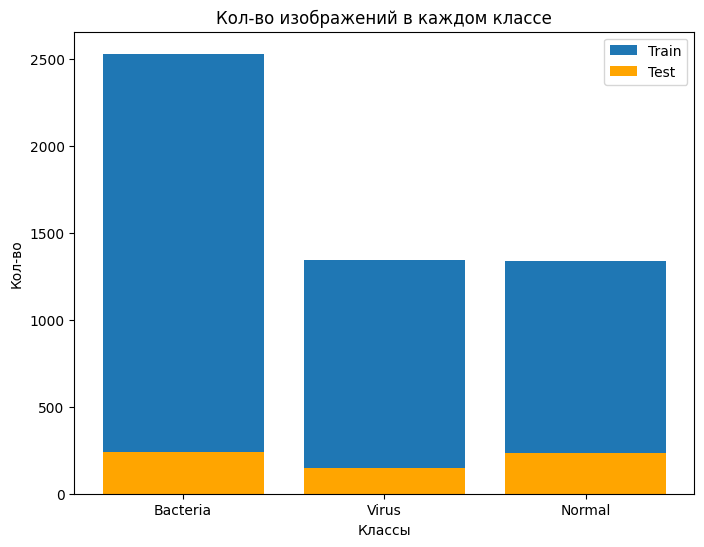

In [11]:
category_counts_train = df_train['class'].value_counts()
category_counts_test = df_test['class'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(category_counts_train.index, category_counts_train.values, label='Train')
plt.bar(category_counts_test.index, category_counts_test.values, color='orange', label='Test')
plt.xlabel('Классы')
plt.ylabel('Кол-во')
plt.title('Кол-во изображений в каждом классе')
plt.legend()
plt.show()

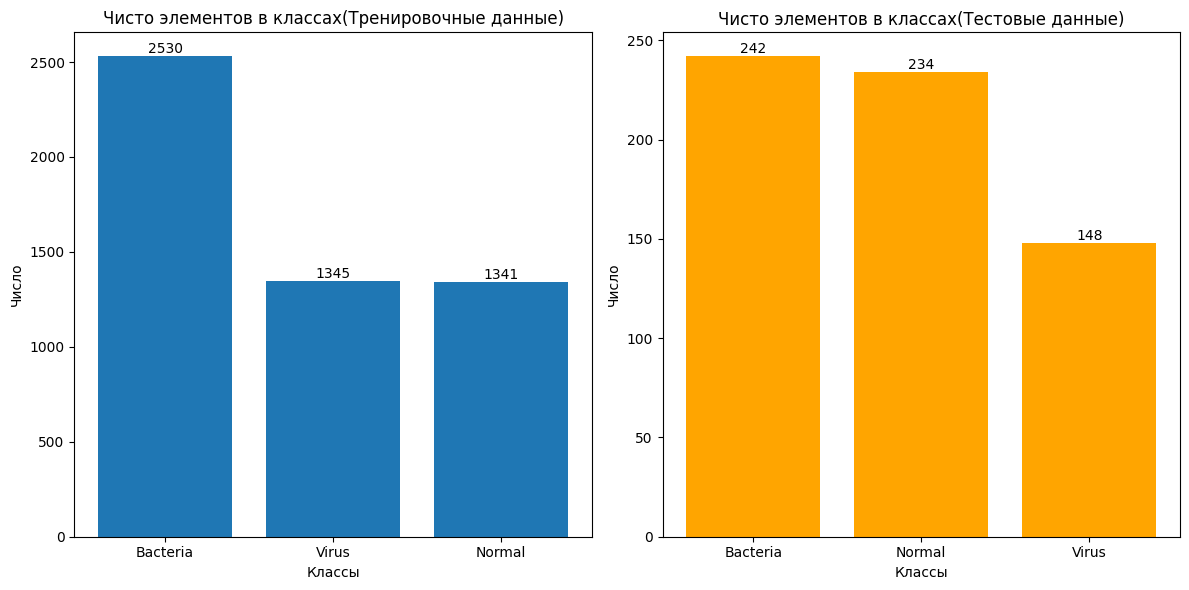

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# График для тренировочных
category_counts_train = df_train['class'].value_counts()
axes[0].bar(category_counts_train.index, category_counts_train.values)

for i, count in enumerate(category_counts_train.values):
    axes[0].text(i, count, str(count), ha='center', va='bottom')

axes[0].set_xlabel('Классы')
axes[0].set_ylabel('Число')
axes[0].set_title('Чисто элементов в классах(Тренировочные данные)')

# График для тестовых
category_counts_test = df_test['class'].value_counts()
axes[1].bar(category_counts_test.index, category_counts_test.values, color='orange')

for i, count in enumerate(category_counts_test.values):
    axes[1].text(i, count, str(count), ha='center', va='bottom')

axes[1].set_xlabel('Классы')
axes[1].set_ylabel('Число')
axes[1].set_title('Чисто элементов в классах(Тестовые данные)')

plt.tight_layout()
plt.show()

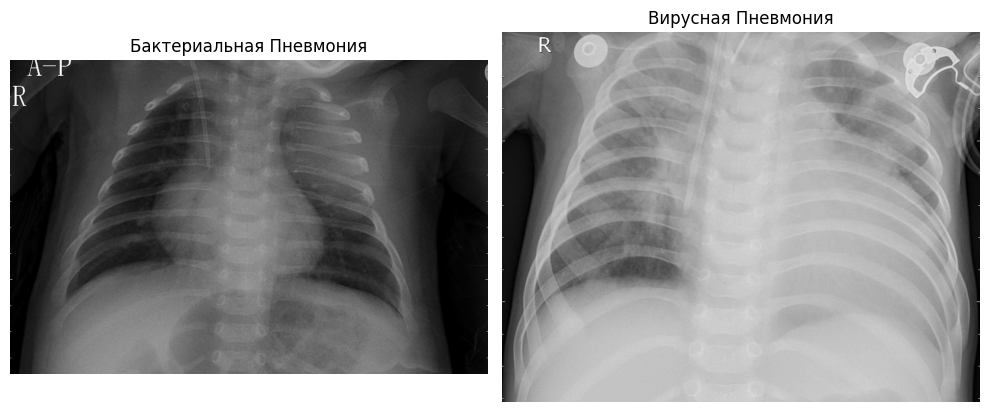

In [13]:
# Посмотрим на вирусную и бактериальную пневмонию
sample_bacteria_img = mpimg.imread(train_bacteria[2])
sample_virus_img = mpimg.imread(train_virus[5])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sample_bacteria_img, cmap='gray')
axes[0].set_title('Бактериальная Пневмония')
axes[0].axis('off')

axes[1].imshow(sample_virus_img, cmap='gray')
axes[1].set_title('Вирусная Пневмония')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### <<С*тарый подход без разделения на вирусную и бактериальную*>>

In [ ]:
# Пути:
# TRAIN_DIR = "/content/chest_xray/train"
# TEST_DIR = "/content/chest_xray/test"
# VAL_DIR = "/content/chest_xray/val"

# main_path = "/content/chest_xray/"

# train_path = os.path.join(main_path,"train")
# test_path=os.path.join(main_path,"test")

# train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
# train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

# test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
# test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [ ]:
# train_list = [x for x in train_normal]
# train_list.extend([x for x in train_pneumonia])

# df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
# df_train['image'] = [x for x in train_list]

# test_list = [x for x in test_normal]
# test_list.extend([x for x in test_pneumonia])

# df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
# df_test['image'] = [x for x in test_list]

In [ ]:
# В этом коде мы используем функцию `train_test_split` из библиотеки `sklearn.model_selection`, 
# Чтобы разделить данные на обучающую и валидационную выборки с использованием стратифицированного разбиения. 
# 80% тренировочных and 20% проверочных.

# from sklearn.model_selection import train_test_split

# train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])


In [ ]:
#Функция аугментации 
#Используем flow_from_dataframe

# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale=1/255.,
#                                   zoom_range = 0.1,
#                                   #rotation_range = 0.1,
#                                   width_shift_range = 0.1,
#                                   height_shift_range = 0.1)

# val_datagen = ImageDataGenerator(rescale=1/255.)

# ds_train = train_datagen.flow_from_dataframe(train_df,
#                                              #directory=train_path, #dataframe contains the full paths
#                                              x_col = 'image',
#                                              y_col = 'class',
#                                              target_size = (IMG_SIZE, IMG_SIZE),
#                                              class_mode = 'binary',
#                                              batch_size = BATCH,
#                                              seed = SEED)

# ds_val = val_datagen.flow_from_dataframe(val_df,
#                                             #directory=train_path,
#                                             x_col = 'image',
#                                             y_col = 'class',
#                                             target_size = (IMG_SIZE, IMG_SIZE),
#                                             class_mode = 'binary',
#                                             batch_size = BATCH,
#                                             seed = SEED)

# ds_test = val_datagen.flow_from_dataframe(df_test,
#                                             #directory=test_path,
#                                             x_col = 'image',
#                                             y_col = 'class',
#                                             target_size = (IMG_SIZE, IMG_SIZE),
#                                             class_mode = 'binary',
#                                             batch_size = 1,
#                                             shuffle = False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


Text(0.5, 1.0, 'Нормировка + аугментация')

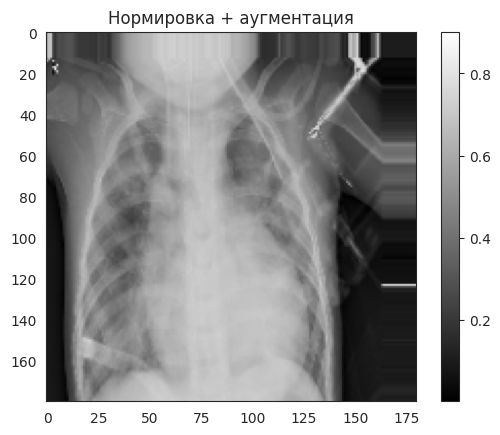

In [ ]:
# Пример изображения с аугментацией и нормировкой 

# sns.set_style('white')
# generated_image, label = ds_train.__getitem__(6)
# plt.imshow(generated_image[0], cmap='gray')
# plt.colorbar()
# plt.title('Нормировка + аугментация')

### <Новый подход с разделением на вирусную и бактериальную>

In [14]:
from sklearn.model_selection import train_test_split

# Расположение файлов
main_path = "/content/chest_xray/"
train_path = os.path.join(main_path, "train")
test_path = os.path.join(main_path, "test")

# Размеры
IMG_SIZE = (224, 224)
BATCH = 32
SEED = 42

# Пути
train_normal = glob.glob(train_path + "/NORMAL/*.jpeg")
train_bacteria = glob.glob(train_path + "/PNEUMONIA/*bacteria*.jpeg")
train_virus = glob.glob(train_path + "/PNEUMONIA/*virus*.jpeg")

test_normal = glob.glob(test_path + "/NORMAL/*.jpeg")
test_bacteria = glob.glob(test_path + "/PNEUMONIA/*bacteria*.jpeg")
test_virus = glob.glob(test_path + "/PNEUMONIA/*virus*.jpeg")

# Датафрейм
train_list = [x for x in train_normal]
train_list.extend([x for x in train_bacteria])
train_list.extend([x for x in train_virus])

df_train = pd.DataFrame(
    np.concatenate(
        [
            ["Normal"] * len(train_normal),
            ["Bacteria"] * len(train_bacteria),
            ["Virus"] * len(train_virus),
        ]
    ),
    columns=["class"],
)
df_train["image"] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_bacteria])
test_list.extend([x for x in test_virus])

df_test = pd.DataFrame(
    np.concatenate(
        [
            ["Normal"] * len(test_normal),
            ["Bacteria"] * len(test_bacteria),
            ["Virus"] * len(test_virus),
        ]
    ),
    columns=["class"],
)
df_test["image"] = [x for x in test_list]

# Разобьем на вирусные и бактериальные
df_train_normal = df_train[df_train["class"].isin(["Normal"])]
df_train_bacteria = df_train[df_train["class"].str.contains("Bacteria")]
df_train_virus = df_train[df_train["class"].str.contains("Virus")]

# Разбиваем на тренировочные и тестовы 
train_df_normal, val_df_normal = train_test_split(
    df_train_normal, test_size=0.20, random_state=SEED, stratify=df_train_normal["class"]
)
train_df_bacteria, val_df_bacteria = train_test_split(
    df_train_bacteria, test_size=0.20, random_state=SEED, stratify=df_train_bacteria["class"]
)
train_df_virus, val_df_virus = train_test_split(
    df_train_virus, test_size=0.20, random_state=SEED, stratify=df_train_virus["class"]
)

# Собираем все
train_df = pd.concat([train_df_normal, train_df_bacteria, train_df_virus])
val_df = pd.concat([val_df_normal, val_df_bacteria, val_df_virus])

In [15]:
from keras.preprocessing.image import ImageDataGenerator

# Аугментатор
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Применяем к ds_train, ds_val и ds_test
ds_train = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH,
    seed=SEED,
)

ds_val = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH,
    seed=SEED,
)

ds_test = val_datagen.flow_from_dataframe(
    df_test,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
)

Found 4172 validated image filenames belonging to 3 classes.
Found 1044 validated image filenames belonging to 3 classes.
Found 624 validated image filenames belonging to 3 classes.


## Сборка модели

Соберем сначала свою собственную модель: (собрал модель, основу которой брал у людей из kaggle) 

### Пробная модель

In [13]:
model_test = Sequential()

model_test.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
model_test.add(BatchNormalization())
model_test.add(MaxPool2D((2, 2), strides=2, padding='same'))
model_test.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model_test.add(Dropout(0.1))
model_test.add(BatchNormalization())
model_test.add(MaxPool2D((2, 2), strides=2, padding='same'))
model_test.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model_test.add(BatchNormalization())
model_test.add(MaxPool2D((2, 2), strides=2, padding='same'))
model_test.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model_test.add(Dropout(0.2))
model_test.add(BatchNormalization())
model_test.add(MaxPool2D((2, 2), strides=2, padding='same'))
model_test.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
model_test.add(Dropout(0.2))
model_test.add(BatchNormalization())
model_test.add(MaxPool2D((2, 2), strides=2, padding='same'))
model_test.add(Flatten())
model_test.add(Dense(units=128, activation='relu'))
model_test.add(Dropout(0.2))
model_test.add(Dense(units=3, activation='softmax'))
model_test.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model_test.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 batch_normalization_7 (Batc  (None, 112, 112, 64)    

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)


model_test.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Тренируем
history = model_test.fit(
    ds_train,
    validation_data=ds_val,
    epochs=4,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

# Результаты
test_loss, test_accuracy = model_test.evaluate(ds_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/4
131/131 [==============================] - 953s 7s/step - loss: 1.5828 - accuracy: 0.5896 - val_loss: 7.2266 - val_accuracy: 0.4847 - lr: 0.0010
Epoch 2/4
131/131 [==============================] - 912s 7s/step - loss: 0.7440 - accuracy: 0.6683 - val_loss: 5.2107 - val_accuracy: 0.4722 - lr: 0.0010
Epoch 3/4
131/131 [==============================] - 897s 7s/step - loss: 0.6824 - accuracy: 0.7006 - val_loss: 1.9026 - val_accuracy: 0.4693 - lr: 0.0010
Epoch 4/4
131/131 [==============================] - ETA: 0s - loss: 0.6401 - accuracy: 0.7239
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
624/624 [==============================] - 34s 55ms/step - loss: 10.2470 - accuracy: 0.3878
Test Loss: 10.2470
Test Accuracy: 0.3878


Столкнулись с проблемой переобучения, пробовал добавлять регуляризации и droput rate, но они особо не помогли, попробуем тогда пересобрать модель

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import RMSprop
from keras.regularizers import l2

# Define the model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [18]:
# Тренирум
history = model.fit(ds_train, 
                    validation_data=ds_val, 
                    epochs=4)

# Точность
loss, accuracy = model.evaluate(ds_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/4
131/131 [==============================] - 681s 5s/step - loss: 1.3143 - accuracy: 0.5336 - val_loss: 0.9178 - val_accuracy: 0.5958
Epoch 2/4
131/131 [==============================] - 691s 5s/step - loss: 0.8977 - accuracy: 0.6239 - val_loss: 0.8819 - val_accuracy: 0.6274
Epoch 3/4
131/131 [==============================] - 691s 5s/step - loss: 0.8404 - accuracy: 0.6577 - val_loss: 0.7875 - val_accuracy: 0.7011
Epoch 4/4
624/624 [==============================] - 33s 52ms/step - loss: 0.7137 - accuracy: 0.7644
Test Loss: 0.713653564453125
Test Accuracy: 0.7644230723381042


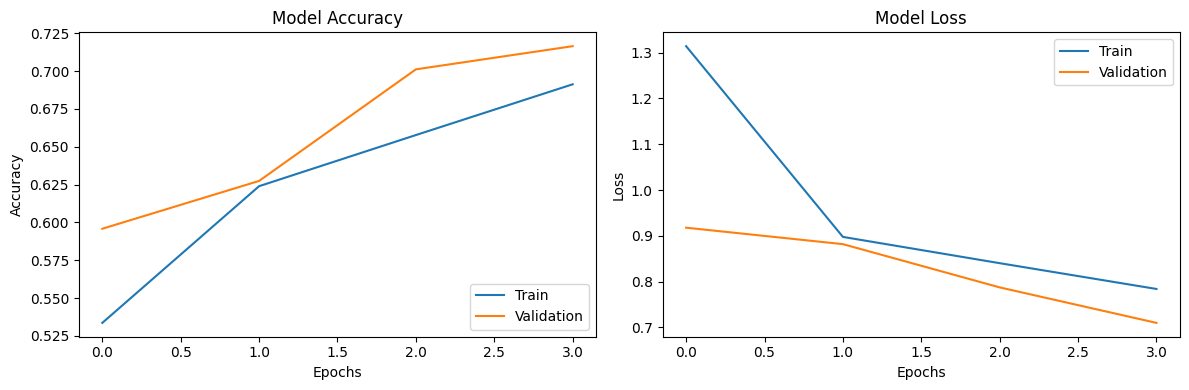

In [19]:
# График

def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Рисуем
plot_history(history)

In [21]:
# Проверка точности на тестовых и тренировочных данных 

evaluation = model.evaluate(ds_test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(ds_train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 61s 97ms/step - loss: 0.7137 - accuracy: 0.7644
Test Accuracy: 76.44%
131/131 [==============================] - 266s 2s/step - loss: 0.7021 - accuracy: 0.7339
Train Accuracy: 73.39%


624/624 [==============================] - 40s 63ms/step


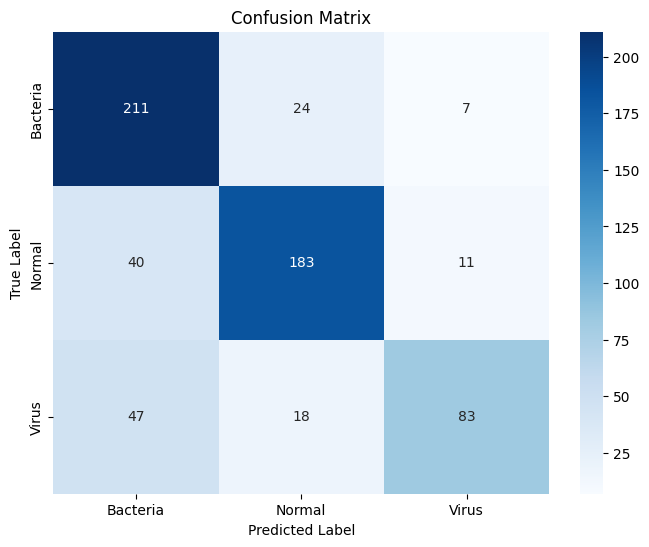

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns



y_true = ds_test.classes
y_pred = model.predict(ds_test)
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# График 
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=ds_test.class_indices,
    yticklabels=ds_test.class_indices,
    cmap="Blues",
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Как мы увидим ниже на предобученной сети(здесь это тоже видно), сеть неплохо отличает здоровые легкие от больных, а так же бактериальные(что не удивительно, т.к. тренировка происходит в основном на них), основная проблема заключается в том, чтобы отличить вирусный от бактериальных - они очень схожи.

624/624 [==============================] - 32s 51ms/step


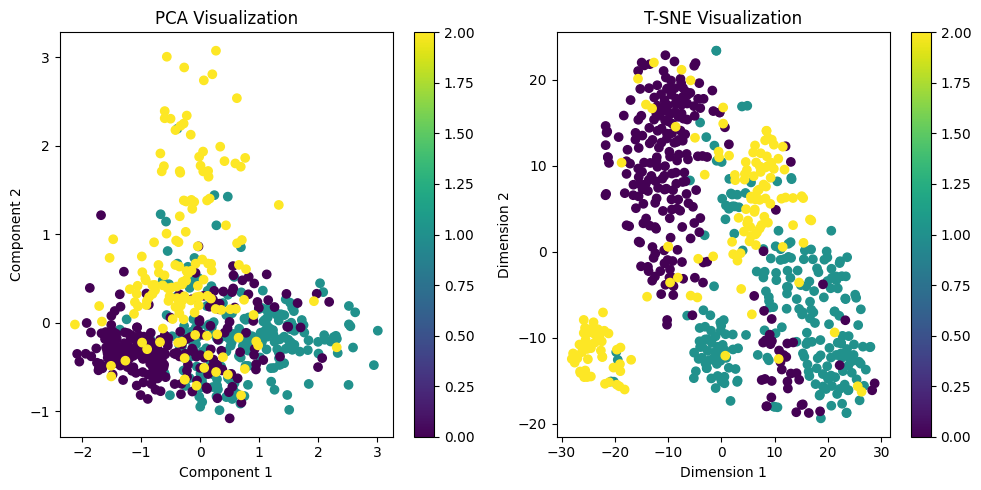

In [23]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Obtain the feature vectors from the trained model
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('flatten').output)
features = feature_extractor.predict(ds_test)

# Perform dimensionality reduction with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Perform dimensionality reduction with T-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(features)

# Plot PCA visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_true, cmap='viridis')
plt.title('PCA Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()

# Plot T-SNE visualization
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_true, cmap='viridis')
plt.title('T-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()

plt.tight_layout()
plt.show()

## Transfer Learning

### ResNet152V2 только для двух классов(здоровые и больные)

In [ ]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(180, 180, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    inputs = layers.Input(shape=(180, 180, 3))
    
    x = base_model(inputs)

    # Основание
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    # Последний слой
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [ ]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 6, 6, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
BATCH = 64 #увеличим для теста размер в 2 раза 

history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 3,
          validation_data=ds_val,
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/3
65/65 [==============================] - 1042s 16s/step - loss: 0.1770 - binary_accuracy: 0.9342 - val_loss: 0.1279 - val_binary_accuracy: 0.9651
Epoch 2/3
65/65 [==============================] - 1066s 16s/step - loss: 0.1610 - binary_accuracy: 0.9356 - val_loss: 0.1356 - val_binary_accuracy: 0.9504
Epoch 3/3
65/65 [==============================] - 956s 15s/step - loss: 0.1755 - binary_accuracy: 0.9309 - val_loss: 0.1151 - val_binary_accuracy: 0.9577


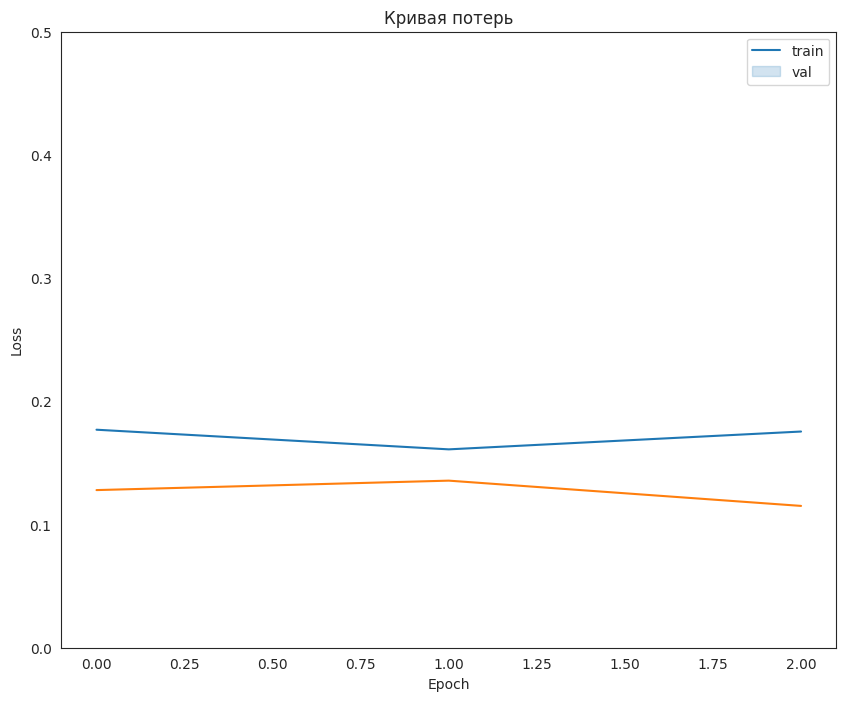

In [ ]:
# График потерь 
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Кривая потерь')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

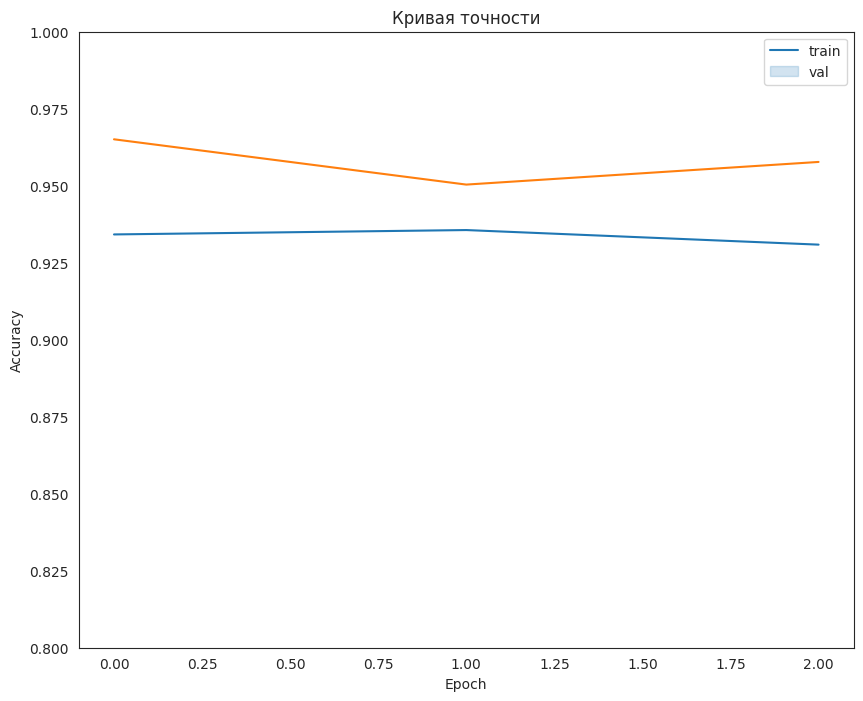

In [ ]:
# График точности
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Кривая точности')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
evaluation = model_pretrained.evaluate(ds_test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model_pretrained.evaluate(ds_train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 317s 508ms/step - loss: 0.3741 - binary_accuracy: 0.8478
Test Accuracy: 84.78%
131/131 [==============================] - 1574s 12s/step - loss: 0.1399 - binary_accuracy: 0.9499
Train Accuracy: 94.99%


Видно, что в случае с двумя классами ResNet152V2 почти сразу же решает поставленную задачу, двух эпох уже хватает, чтобы добиться очень высокой точности. Это связано с тем, что сеть изначальна натренирована на очень схожем наборе данных. 

### Xception model для 3х классов(здоровые, вирусные и бактериальные)

Больший интерес составляет задача классификации для трех классов (теперь больные легкие распадаются на вирусные и бактериальные), для решения этой задачи будем использовать предобученную Xception

In [ ]:
# Подгрузим модель Xception
base_model = tf.keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,),
)

# Замораживаем
base_model.trainable = False

# Настроим под наши данные 
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Компилируем модель(оптимизатор - Адам, по классике)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


In [21]:
# Тренируем
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=5,
)

# Результаты
loss, accuracy = model.evaluate(ds_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/5
131/131 [==============================] - 1418s 11s/step - loss: 0.6326 - accuracy: 0.7251 - val_loss: 0.6295 - val_accuracy: 0.7126
Epoch 2/5
131/131 [==============================] - 1295s 10s/step - loss: 0.5566 - accuracy: 0.7634 - val_loss: 0.5659 - val_accuracy: 0.7519
Epoch 3/5
131/131 [==============================] - 1298s 10s/step - loss: 0.5440 - accuracy: 0.7718 - val_loss: 0.6070 - val_accuracy: 0.7308
Epoch 4/5
131/131 [==============================] - 1304s 10s/step - loss: 0.5309 - accuracy: 0.7711 - val_loss: 0.5500 - val_accuracy: 0.7557
Epoch 5/5
624/624 [==============================] - 154s 246ms/step - loss: 0.7393 - accuracy: 0.7772
Test Loss: 0.7393
Test Accuracy: 0.7772


До этого пробовал обучать на большем кол-ве эпох(10) 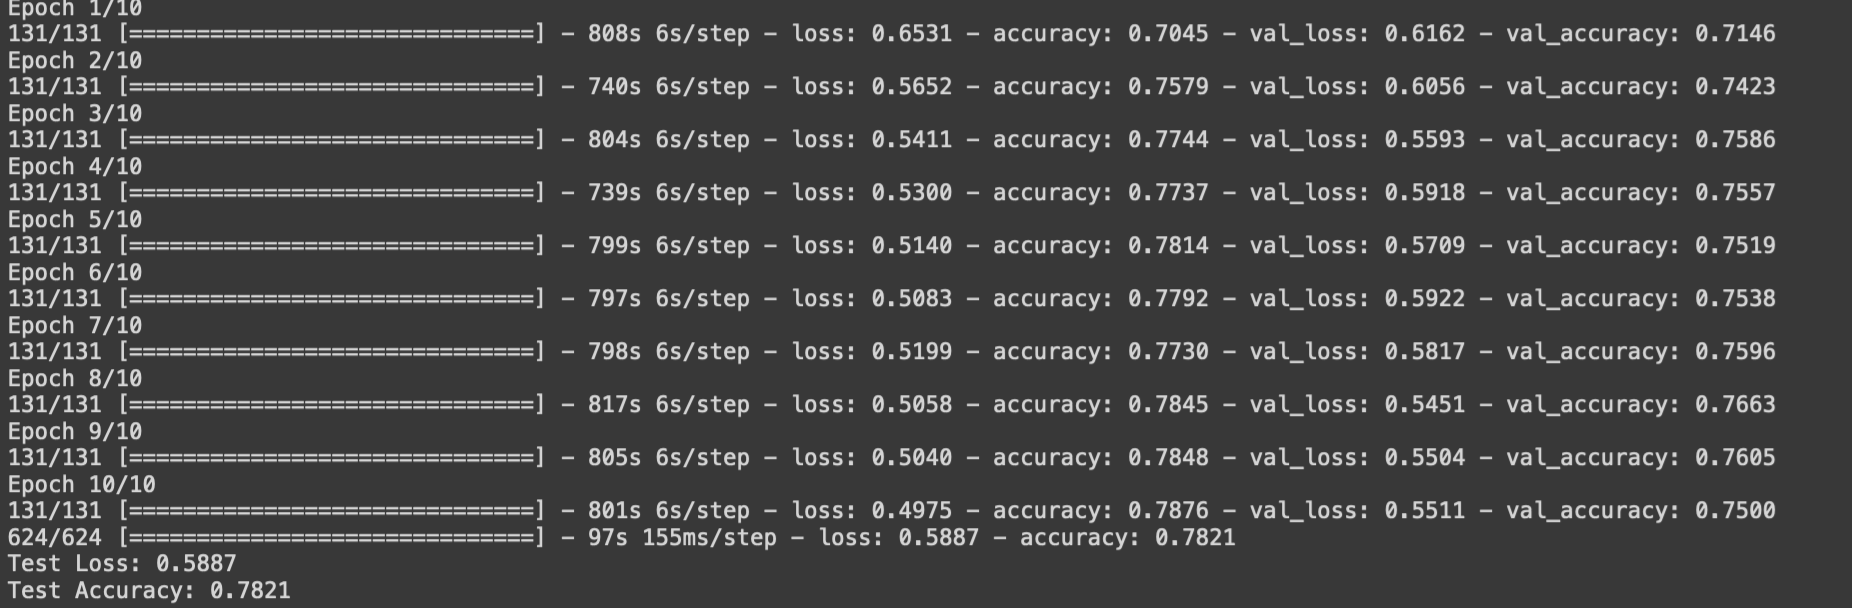), но это не дало существенный вклад в точность

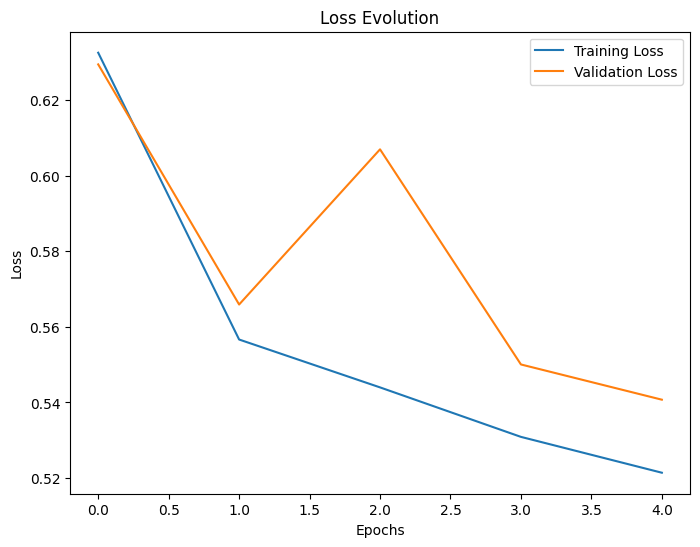

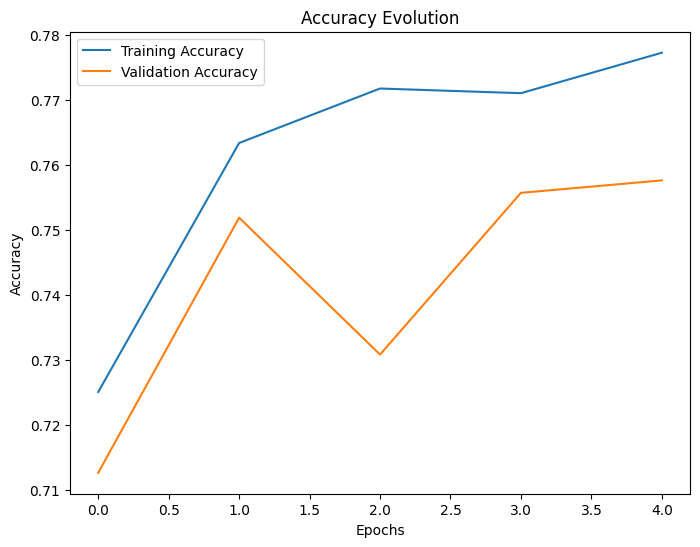

624/624 [==============================] - 196s 313ms/step - loss: 0.7393 - accuracy: 0.7772
Test Loss: 0.7393
Test Accuracy: 0.7772
624/624 [==============================] - 177s 280ms/step


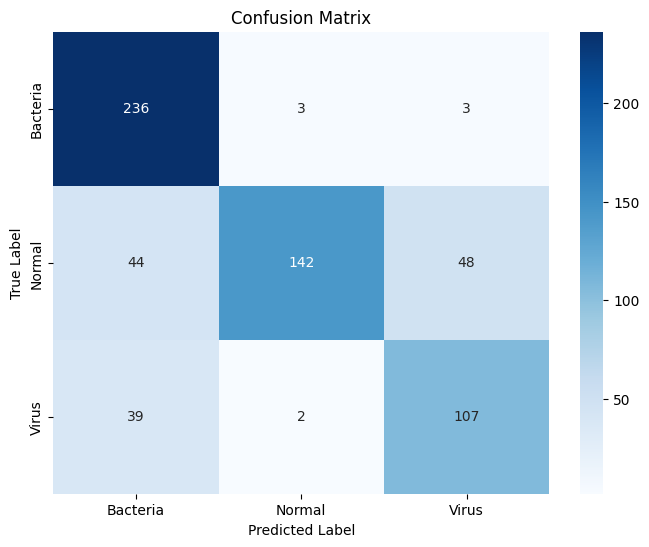

In [22]:
from sklearn.metrics import confusion_matrix

# Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Evolution")
plt.show()

# Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Evolution")
plt.show()

# Подсчет на тестовом наборе
loss, accuracy = model.evaluate(ds_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Предсказания
y_pred = model.predict(ds_test)
y_true = ds_test.classes

# Матрица ошибок
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# График матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=ds_test.class_indices,
    yticklabels=ds_test.class_indices,
    cmap="Blues",
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Ниже представлена матрица ошибок и графики для 10 эпох: 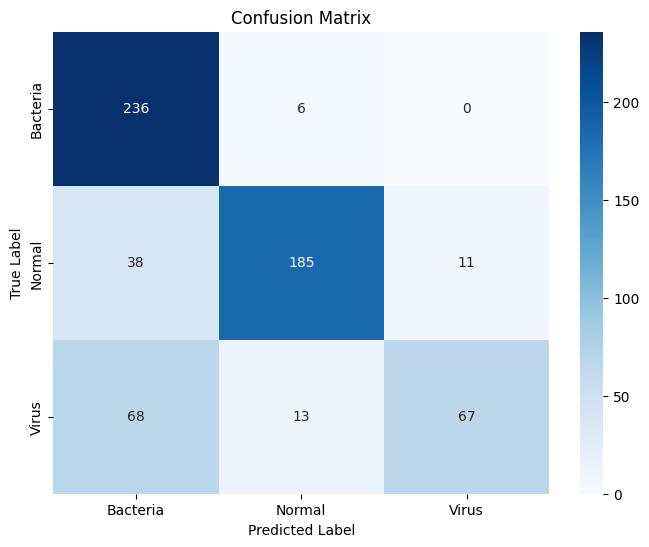

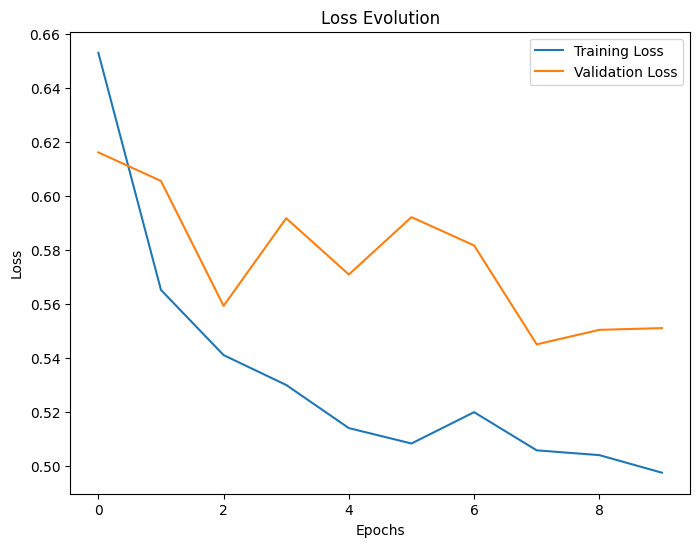 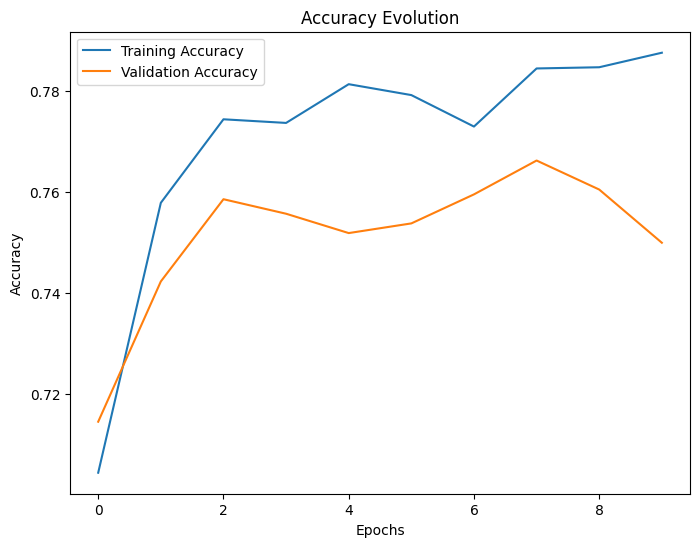

Не смотря на то, что точность в районе 80% - для такого датасета это весьма высокий результат. По матрице ошибок видно, что бактериальные и здоровые легкие определяются достаточно точно. Основная проблема содержится в попытке отличить вирусные от бактериальных (причем интересно, что бактериальные сеть определяет всегда, а вот вирусные часто путает с бактериальными) - Как мы видели выше, визуально не профессионалу иногда довольно сложно отличить вирусную от бактериальной. Самое главное - в случае больных легких сеть почти не ошибается, ошибочное предположение, что легкие здоровы было сделано суммарно только 19 раз.